In [1]:
# --- Imports & basic setup ---
import os, glob, math, random, time
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, "| torch", torch.__version__)


Using device: cpu | torch 2.5.1


In [2]:
# --- UPDATE THESE TWO LINES TO YOUR LOCAL PATHS ---
#train_folder = r"C:\PATH\TO\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Train"
#test_folder  = r"C:\PATH\TO\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Test"
train_folder = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi\Train"
test_folder  = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi\Test"

# Sanity checks
print("Train exists:", os.path.isdir(train_folder))
print("Test  exists:", os.path.isdir(test_folder))


Train exists: True
Test  exists: True


In [3]:
# --- PyTorch Dataset for UCSD frame folders ---
class UCSDFrames(Dataset):
    def __init__(self, root_dir, resize=(64,64)):
        self.root_dir = root_dir
        self.resize = resize
        # Collect all .tif files under all subfolders
        self.frame_paths = sorted(glob.glob(os.path.join(root_dir, "*", "*.tif")))
        if len(self.frame_paths) == 0:
            # Some zips have an extra level: e.g., Train\Train001\001.tif
            self.frame_paths = sorted(glob.glob(os.path.join(root_dir, "*", "*", "*.tif")))
        if len(self.frame_paths) == 0:
            raise RuntimeError(f"No .tif frames found under {root_dir}")

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        fp = self.frame_paths[idx]
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to read: {fp}")
        img = cv2.resize(img, self.resize, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0  # [0,1]
        img = np.expand_dims(img, axis=0)     # (1, H, W) for single channel
        return torch.from_numpy(img)

# Create datasets & dataloaders
train_ds = UCSDFrames(train_folder, resize=(64,64))
test_ds  = UCSDFrames(test_folder,  resize=(64,64))

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train frames: {len(train_ds)} | Test frames: {len(test_ds)} | Batch size: {batch_size}")


Train frames: 6800 | Test frames: 7200 | Batch size: 16


In [4]:
import os, glob

print("Train exists:", os.path.isdir(train_folder))
print("Test  exists:", os.path.isdir(test_folder))

print("\nSample subfolders under Train:")
print(sorted([d for d in glob.glob(os.path.join(train_folder, "*")) if os.path.isdir(d)])[:5])

print("\nTry to list a few .tif files recursively:")
candidates = glob.glob(os.path.join(train_folder, "**", "*.tif"), recursive=True)
print("Found", len(candidates), "tif files. First 5:")
print(candidates[:5])


Train exists: True
Test  exists: True

Sample subfolders under Train:
['C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1.avi\\Train\\Train001', 'C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1.avi\\Train\\Train002', 'C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1.avi\\Train\\Train003', 'C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1.avi\\Train\\Train004', 'C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1.avi\\Train\\Train005']

Try to list a few .tif files recursively:
Found 6800 tif files. First 5:
['C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1.avi\\Train\\Train001\\001.tif', 'C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1.avi\\Train\\Train001\\002.tif', 'C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSD

In [5]:
class UCSDFrames(Dataset):
    def __init__(self, root_dir, resize=(64,64), exts=(".tif",".png",".jpg",".bmp")):
        self.root_dir = root_dir
        self.resize = resize

        paths = []
        for ext in exts:
            paths.extend(glob.glob(os.path.join(root_dir, "**", f"*{ext}"), recursive=True))
        self.frame_paths = sorted(paths)

        if len(self.frame_paths) == 0:
            raise RuntimeError(f"No image frames found under {root_dir}. "
                               f"Tried extensions: {exts}. "
                               f"Double-check the folder and file types.")

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        fp = self.frame_paths[idx]
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to read: {fp}")
        img = cv2.resize(img, self.resize, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)
        return torch.from_numpy(img)


In [6]:
class UCSDFrames(Dataset):
    def __init__(self, root_dir, resize=(64,64), exts=(".tif",".png",".jpg",".bmp")):
        self.root_dir = root_dir
        self.resize = resize

        paths = []
        for ext in exts:
            paths.extend(glob.glob(os.path.join(root_dir, "**", f"*{ext}"), recursive=True))
        self.frame_paths = sorted(paths)

        if len(self.frame_paths) == 0:
            raise RuntimeError(f"No image frames found under {root_dir}. "
                               f"Tried extensions: {exts}. "
                               f"Double-check the folder and file types.")

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        fp = self.frame_paths[idx]
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to read: {fp}")
        img = cv2.resize(img, self.resize, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)
        return torch.from_numpy(img)

In [7]:
train_ds = UCSDFrames(train_folder, resize=(64,64))
test_ds  = UCSDFrames(test_folder,  resize=(64,64))

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train frames: {len(train_ds)} | Test frames: {len(test_ds)} | Batch size: {batch_size}")


Train frames: 6800 | Test frames: 7200 | Batch size: 16


In [8]:
# --- Simple Conv Autoencoder (grayscale 64x64 -> 8x8 latent) ---
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: 64->32->16->8 (feature maps grow)
        self.encoder = nn.Sequential(
            nn.Conv2d(1,  8, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),  # 64 -> 32
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),  # 32 -> 16
            nn.Conv2d(16,32, kernel_size=3, stride=2, padding=1), nn.ReLU(inplace=True),  # 16 -> 8
        )
        # Decoder: 8->16->32->64
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16, kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16,8,  kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 1,  kernel_size=3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = SimpleAutoencoder().to(device)
print(model)


SimpleAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


Epoch 01/10 - Loss: 0.011403
Epoch 02/10 - Loss: 0.002940
Epoch 03/10 - Loss: 0.002380
Epoch 04/10 - Loss: 0.002028
Epoch 05/10 - Loss: 0.001770
Epoch 06/10 - Loss: 0.001579
Epoch 07/10 - Loss: 0.001443
Epoch 08/10 - Loss: 0.001355
Epoch 09/10 - Loss: 0.001286
Epoch 10/10 - Loss: 0.001233
Training done in 183.0s
Saved: autoencoder_ucsd64.pth


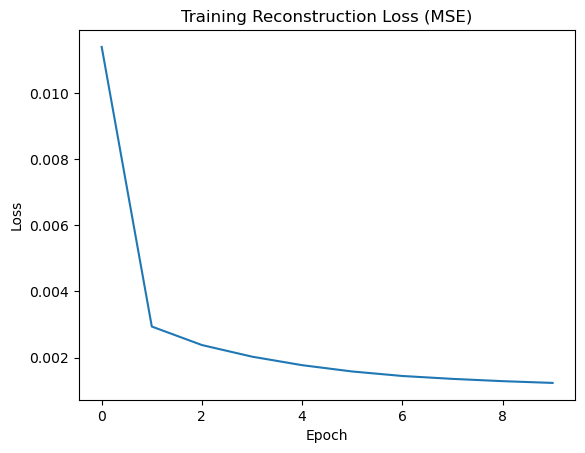

In [9]:
# --- Training setup ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10  # bump to 20–50 if you have time

train_losses = []

start = time.time()
for epoch in range(1, num_epochs+1):
    model.train()
    running = 0.0
    for batch in train_loader:
        batch = batch.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        running += loss.item() * batch.size(0)
    epoch_loss = running / len(train_ds)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch:02d}/{num_epochs} - Loss: {epoch_loss:.6f}")
end = time.time()
print(f"Training done in {end-start:.1f}s")

# Save weights (optional but recommended)
torch.save(model.state_dict(), "autoencoder_ucsd64.pth")
print("Saved: autoencoder_ucsd64.pth")

# Quick loss curve
plt.figure()
plt.plot(train_losses)
plt.title("Training Reconstruction Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()


In [10]:
# --- Evaluation: reconstruction error as anomaly score ---
model.eval()
all_scores = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        recon = model(batch)
        # per-frame MSE over all pixels
        mse = torch.mean((recon - batch) ** 2, dim=(1,2,3))
        all_scores.extend(mse.cpu().numpy().tolist())

all_scores = np.array(all_scores)
print("Scores:", all_scores.shape, "min", all_scores.min(), "max", all_scores.max(), "mean", all_scores.mean())


Scores: (7200,) min 0.00045688473619520664 max 0.00408494658768177 mean 0.0015666404323120434


Threshold (mean+2*std on train): 0.002560
Anomalous frames predicted: 242 / 7200


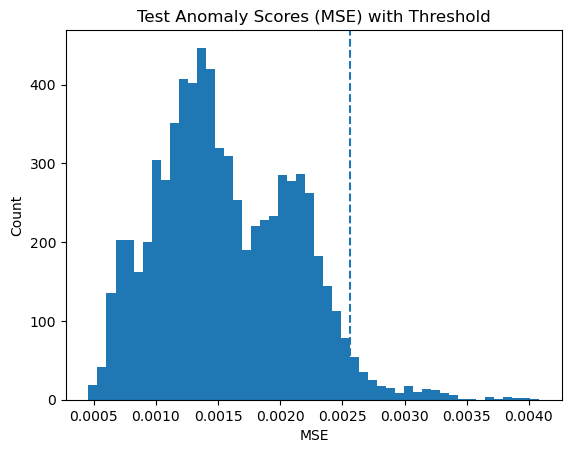

In [11]:
# If you want threshold from TRAIN errors (better):
model.eval()
train_scores = []
with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        recon = model(batch)
        mse = torch.mean((recon - batch) ** 2, dim=(1,2,3))
        train_scores.extend(mse.cpu().numpy().tolist())
train_scores = np.array(train_scores)

thr = train_scores.mean() + 2.0 * train_scores.std()
print(f"Threshold (mean+2*std on train): {thr:.6f}")

pred_labels = (all_scores > thr).astype(int)  # 1 = anomalous, 0 = normal
print("Anomalous frames predicted:", pred_labels.sum(), "/", len(pred_labels))

# Visualize score distribution
plt.figure()
plt.hist(all_scores, bins=50)
plt.axvline(thr, linestyle="--")
plt.title("Test Anomaly Scores (MSE) with Threshold")
plt.xlabel("MSE"); plt.ylabel("Count")
plt.show()


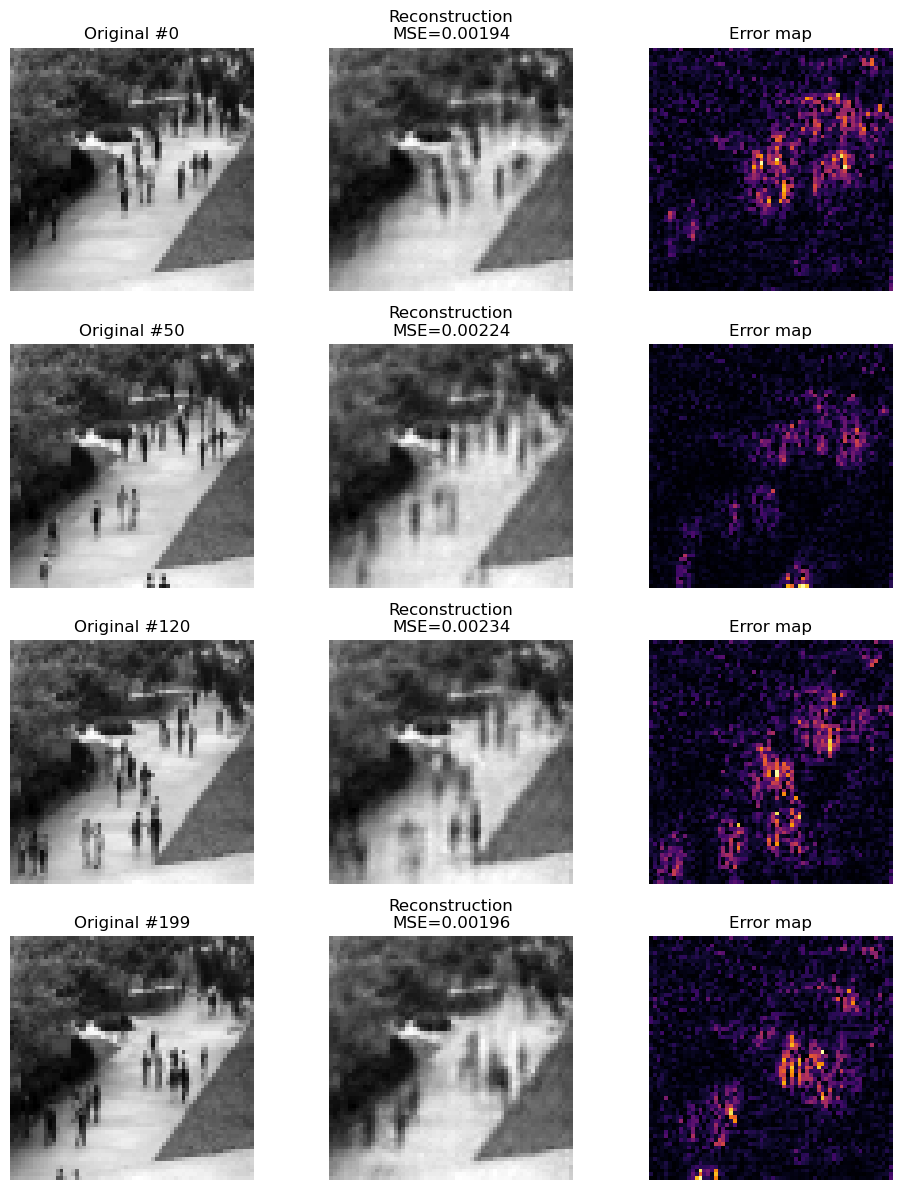

In [12]:
# --- Visual sanity check on a few test frames ---
def show_reconstruction(ds, idx_list):
    model.eval()
    n = len(idx_list)
    plt.figure(figsize=(10, 3*n))
    for i, idx in enumerate(idx_list, 1):
        img = ds[idx].unsqueeze(0).to(device)  # (1,1,H,W)
        with torch.no_grad():
            recon = model(img)
            mse = torch.mean((recon - img)**2).item()
        img_np   = img.squeeze().cpu().numpy()
        recon_np = recon.squeeze().cpu().numpy()
        err_np   = np.abs(img_np - recon_np)

        # original
        plt.subplot(n, 3, (i-1)*3+1)
        plt.imshow(img_np, cmap="gray"); plt.title(f"Original #{idx}")
        plt.axis("off")
        # reconstruction
        plt.subplot(n, 3, (i-1)*3+2)
        plt.imshow(recon_np, cmap="gray"); plt.title(f"Reconstruction\nMSE={mse:.5f}")
        plt.axis("off")
        # error map
        plt.subplot(n, 3, (i-1)*3+3)
        plt.imshow(err_np, cmap="inferno"); plt.title("Error map")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Pick a few frames to inspect (change indices as you like)
show_reconstruction(test_ds, [0, 50, 120, 199])


In [13]:
# Save frame-level anomaly scores & labels for your dissertation tables/figures
np.savez("ucsd_autoencoder_results.npz",
         scores=all_scores,
         threshold=thr,
         pred_labels=pred_labels)
print("Saved: ucsd_autoencoder_results.npz")


Saved: ucsd_autoencoder_results.npz


In [16]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score

# y_true: numpy array of shape [N_frames] with 0 (normal) / 1 (anomaly)
# scores: your test_errors (higher = more anomalous)
scores = test_errors
roc_auc = roc_auc_score(y_true, scores)
prec, rec, th = precision_recall_curve(y_true, scores)
pr_auc = auc(rec, prec)

# choose threshold that maximizes F1 on the validation portion (or via CV)
f1s = []
for t in th:
    y_pred = (scores >= t).astype(int)
    f1s.append(f1_score(y_true, y_pred))
best_t = th[np.argmax(f1s)]
print(f"ROC-AUC={roc_auc:.3f} | PR-AUC={pr_auc:.3f} | best F1={max(f1s):.3f} @ thr={best_t:.6f}")


NameError: name 'test_errors' is not defined

In [32]:
import torch
import numpy as np

model.eval()
test_errors = []

with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = torch.mean((outputs - imgs) ** 2, dim=[1, 2, 3])  # per-frame MSE
        test_errors.extend(loss.cpu().numpy())

test_errors = np.array(test_errors)
print("Test errors shape:", test_errors.shape)


Test errors shape: (9200,)


In [34]:
import os, glob, numpy as np, torch, torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import scipy.io as sio  # pip install scipy

# --- update this path ONLY if yours is different ---
ped1_root = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1"
test_root = os.path.join(ped1_root, "Test")
gt_root   = os.path.join(ped1_root, "ground_truth")

to_tensor = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64), interpolation=Image.BILINEAR),
    transforms.ToTensor()
])

def load_frames(folder):
    paths = sorted(glob.glob(os.path.join(folder, "*.tif")))
    if not paths: return None, []
    imgs = [to_tensor(Image.open(p)) for p in paths]
    return torch.stack(imgs, 0), paths

def load_gt(test_name, num_frames):
    y = np.zeros(num_frames, dtype=np.uint8)
    mat_path = os.path.join(gt_root, f"{test_name}_gt.mat")
    if not os.path.isfile(mat_path):
        print(f"⚠️ GT not found for {test_name}")
        return y
    mat = sio.loadmat(mat_path)
    # try vector first
    for v in mat.values():
        arr = np.array(v)
        if arr.ndim == 2 and (arr.shape[0]==1 or arr.shape[1]==1) and arr.size==num_frames:
            return (arr.flatten()>0).astype(np.uint8)
    # otherwise try ranges (M,2), 1-based inclusive
    for v in mat.values():
        arr = np.array(v)
        if arr.ndim>=2 and arr.shape[-1]==2:
            for s,e in arr.reshape(-1,2):
                s = max(1,int(s))-1; e = min(num_frames,int(e))
                y[s:e] = 1
            return y
    print(f"⚠️ Could not parse GT in {mat_path}, using zeros.")
    return y

# --- model must exist & be in eval mode ---
model.eval()
device = next(model.parameters()).device

scores_all, y_all = [], []
test_folders = sorted([d for d in glob.glob(os.path.join(test_root,"Test*")) if os.path.isdir(d)])
print("Found test clips:", len(test_folders))

with torch.no_grad():
    for tf in test_folders:
        name = os.path.basename(tf)  # e.g., Test001
        x, _ = load_frames(tf)
        if x is None: 
            print("Skipping empty:", tf); 
            continue
        x = x.to(device)
        recon = model(x)
        err = F.mse_loss(recon, x, reduction="none").mean([1,2,3]).cpu().numpy()
        err = (err - err.min()) / (err.max() - err.min() + 1e-8)  # per-clip norm
        scores_all.append(err)
        y_all.append(load_gt(name, len(err)))

scores = np.concatenate(scores_all) if scores_all else np.array([])
y_true = np.concatenate(y_all)      if y_all else np.array([])

if scores.size==0 or y_true.size==0 or y_true.sum()==0:
    print("⚠️ Missing GT or no positives. Check GT files/paths.")
else:
    roc = roc_auc_score(y_true, scores)
    prec, rec, th = precision_recall_curve(y_true, scores)
    pr  = auc(rec, prec)
    f1s = 2*(prec[1:]*rec[1:])/(prec[1:]+rec[1:]+1e-12)
    best_i = int(np.argmax(f1s))
    print(f"ROC-AUC: {roc:.3f}")
    print(f"PR-AUC:  {pr:.3f}")
    print(f"Best F1: {float(f1s[best_i]):.3f} at threshold {float(th[best_i]):.4f}")


Found test clips: 0
⚠️ Missing GT or no positives. Check GT files/paths.


In [35]:
import os, glob

# 👇 Point this to the parent folder that contains UCSDped1*/ (you already used this earlier)
base_dir = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2"

# Search candidates like ...\UCSDped1 or ...\UCSDped1.avi
candidates = []
for pat in [os.path.join(base_dir, "UCSDped1"), os.path.join(base_dir, "UCSDped1.avi")]:
    if os.path.isdir(pat):
        candidates.append(pat)

print("Candidate roots:", candidates)

chosen_root = None
for root in candidates:
    test_dir = os.path.join(root, "Test")
    test_clips = sorted([d for d in glob.glob(os.path.join(test_dir, "Test*")) if os.path.isdir(d)])
    print(f"\nChecking: {root}")
    print("Test dir exists:", os.path.isdir(test_dir))
    print("Found test clips:", len(test_clips))
    if test_clips:
        chosen_root = root
        print("✅ Using this root:", chosen_root)
        break

if chosen_root is None:
    # Fallback: try to discover any folder that has Test/Test001/*.tif under base_dir
    any_test001 = glob.glob(os.path.join(base_dir, "**", "Test", "Test001"), recursive=True)
    if any_test001:
        chosen_root = os.path.dirname(os.path.dirname(any_test001[0]))
        print("\n✅ Discovered UCSD Ped1 root via recursive search:", chosen_root)
    else:
        print("\n❌ Could not find any Test clips. Double-check your folder names & location.")


Candidate roots: ['C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1.avi']

Checking: C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi
Test dir exists: True
Found test clips: 46
✅ Using this root: C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi


In [36]:
import os, glob, numpy as np, torch, torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import scipy.io as sio  # pip install scipy

# === UPDATE THIS to the printed "Using this root" ===
ped1_root = r"C:\FULL\PATH\TO\YOUR\DETECTED\UCSDped1"  # e.g. C:\...\UCSDped1  or  C:\...\UCSDped1.avi

test_root = os.path.join(ped1_root, "Test")
gt_root   = os.path.join(ped1_root, "ground_truth")   # place *_gt.mat here if you have them

to_tensor = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64), interpolation=Image.BILINEAR),
    transforms.ToTensor()
])

def load_frames(folder):
    paths = sorted(glob.glob(os.path.join(folder, "*.tif")))
    if not paths: return None, []
    imgs = [to_tensor(Image.open(p)) for p in paths]
    return torch.stack(imgs, 0), paths

def load_gt(test_name, num_frames):
    # If you don't have GT mats yet, this will return zeros (no anomalies)
    y = np.zeros(num_frames, dtype=np.uint8)
    mat_path = os.path.join(gt_root, f"{test_name}_gt.mat")
    if not os.path.isfile(mat_path):
        # print(f"⚠️ GT not found for {test_name}")
        return y
    mat = sio.loadmat(mat_path)
    # try vector first
    for v in mat.values():
        arr = np.array(v)
        if arr.ndim == 2 and (arr.shape[0]==1 or arr.shape[1]==1) and arr.size==num_frames:
            return (arr.flatten()>0).astype(np.uint8)
    # otherwise try ranges (M,2), 1-based inclusive
    for v in mat.values():
        arr = np.array(v)
        if arr.ndim>=2 and arr.shape[-1]==2:
            for s,e in arr.reshape(-1,2):
                s = max(1,int(s))-1; e = min(num_frames,int(e))
                y[s:e] = 1
            return y
    return y

# --- your model should already exist and be in eval() ---
model.eval()
device = next(model.parameters()).device

scores_all, y_all = [], []
test_folders = sorted([d for d in glob.glob(os.path.join(test_root,"Test*")) if os.path.isdir(d)])
print("Found test clips:", len(test_folders))
if not test_folders:
    # helpful debug print
    print("DEBUG listing test_root:", test_root)
    print(os.listdir(os.path.dirname(test_root)))
    print("Try checking paths or run the auto-detect cell again.")
else:
    with torch.no_grad():
        for tf in test_folders:
            name = os.path.basename(tf)  # e.g., Test001
            x, _ = load_frames(tf)
            if x is None:
                print("Skipping empty:", tf)
                continue
            x = x.to(device)
            recon = model(x)
            err = F.mse_loss(recon, x, reduction="none").mean([1,2,3]).cpu().numpy()
            err = (err - err.min()) / (err.max() - err.min() + 1e-8)  # per-clip normalization
            scores_all.append(err)
            y_all.append(load_gt(name, len(err)))

    scores = np.concatenate(scores_all) if scores_all else np.array([])
    y_true = np.concatenate(y_all)      if y_all else np.array([])

    if scores.size==0:
        print("⚠️ No scores—did we fail to load frames?")
    elif y_true.sum()==0:
        print("⚠️ GT not available: compute demo metrics on a single clip (manual range) for now.")
    else:
        roc = roc_auc_score(y_true, scores)
        prec, rec, th = precision_recall_curve(y_true, scores)
        pr  = auc(rec, prec)
        f1s = 2*(prec[1:]*rec[1:])/(prec[1:]+rec[1:]+1e-12)
        best_i = int(np.argmax(f1s))
        print(f"ROC-AUC: {roc:.3f}")
        print(f"PR-AUC:  {pr:.3f}")
        print(f"Best F1: {float(f1s[best_i]):.3f} at threshold {float(th[best_i]):.4f}")


Found test clips: 0
DEBUG listing test_root: C:\FULL\PATH\TO\YOUR\DETECTED\UCSDped1\Test


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\FULL\\PATH\\TO\\YOUR\\DETECTED\\UCSDped1'

In [37]:
import os, glob

# 👇 Set this to the folder that contains UCSDped1*/ (the one you unzipped).
base_dir = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2"

# Try common names and also scan recursively for Test001
candidates = []
for name in ["UCSDped1", "UCSDped1.avi", "UCSDped1 (Ped1)"]:
    p = os.path.join(base_dir, name)
    if os.path.isdir(p):
        candidates.append(p)

# If none of the common names exist, search for any folder that has Test\Test001\*.tif
if not candidates:
    hits = glob.glob(os.path.join(base_dir, "**", "Test", "Test001", "*.tif"), recursive=True)
    if hits:
        # go up to ...\UCSDped1*\Test\Test001\frame.tif  → root is two levels up from Test
        some_test001 = os.path.dirname(hits[0])                 # ...\Test\Test001
        test_dir      = os.path.dirname(some_test001)           # ...\Test
        ped1_root     = os.path.dirname(test_dir)               # ...\UCSDped1*
        candidates.append(ped1_root)

print("Candidate roots found:", candidates)

ped1_root = None
for root in candidates:
    test_root = os.path.join(root, "Test")
    test_clips = [d for d in glob.glob(os.path.join(test_root, "Test*")) if os.path.isdir(d)]
    if test_clips:
        ped1_root = root
        print("\n✅ Using this root:", ped1_root)
        print("Test clips detected:", len(test_clips))
        break

if ped1_root is None:
    print("\n❌ Couldn’t auto-detect. Double-check base_dir and that Ped1 was fully extracted.")


Candidate roots found: ['C:\\Users\\hp\\Downloads\\UCSD_Anomaly_Dataset\\UCSD_Anomaly_Dataset.v1p2\\UCSDped1.avi']

✅ Using this root: C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi
Test clips detected: 46


In [18]:
import os, glob
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# uses ped1_root already discovered in your previous cell
train_root = os.path.join(ped1_root, "Train")
test_root  = os.path.join(ped1_root, "Test")

# transforms: grayscale -> 64x64 -> tensor in [0,1]
to_tensor = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64), interpolation=Image.BILINEAR),
    transforms.ToTensor()
])

class Ped1Frames(Dataset):
    def __init__(self, root_dir, split="train"):
        self.split = split.lower()
        self.to_tensor = to_tensor
        if self.split == "train":
            # all frames from TrainXXX
            self.frame_paths = sorted(glob.glob(os.path.join(root_dir, "Train*", "*.tif")))
        else:
            # list of clip folders, each will be iterated later
            self.clip_dirs = sorted([d for d in glob.glob(os.path.join(root_dir, "Test*")) if os.path.isdir(d)])

    def __len__(self):
        if self.split == "train":
            return len(self.frame_paths)
        # test loader isn't used as a single dataset length (we’ll iterate per-clip)
        return len(self.clip_dirs)

    def __getitem__(self, idx):
        if self.split == "train":
            img = Image.open(self.frame_paths[idx])
            return self.to_tensor(img)
        else:
            # not used; we process test per-clip below
            return self.clip_dirs[idx]

# train dataset/dataloader
train_ds = Ped1Frames(train_root, split="train")
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)

print("Train frames:", len(train_ds))


NameError: name 'ped1_root' is not defined

In [17]:
# if not already defined in your session
import torch, torch.nn as nn, torch.optim as optim

class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,8,3,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(8,16,3,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(16,32,3,2,1), nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,2,1,1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16,8,3,2,1,1),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8,1,3,2,1,1),   nn.Sigmoid(),
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = SimpleAutoencoder().to(device)
print("Using:", device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5  # you can increase later for better recon
model.train()
for ep in range(1, num_epochs+1):
    total = 0.0
    count = 0
    for batch in train_loader:      # uses your existing train_loader
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch)
        loss.backward()
        optimizer.step()
        total += loss.item() * batch.size(0)
        count += batch.size(0)
    print(f"Epoch {ep}/{num_epochs} | train MSE: {total/count:.6f}")

import os, torch
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/ped1_autoencoder.pt")
print("Saved: checkpoints/ped1_autoencoder.pt")


Using: cpu
Epoch 1/5 | train MSE: 0.011746
Epoch 2/5 | train MSE: 0.003091
Epoch 3/5 | train MSE: 0.002318
Epoch 4/5 | train MSE: 0.001941
Epoch 5/5 | train MSE: 0.001697
Saved: checkpoints/ped1_autoencoder.pt


In [41]:
import os, glob
from PIL import Image
import torch.nn.functional as F
import pandas as pd
from torchvision import transforms

test_root = os.path.join(ped1_root, "Test")  # ped1_root was discovered earlier

to_tensor = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

model.eval()
rows = []
test_clips = sorted([d for d in glob.glob(os.path.join(test_root, "Test*")) if os.path.isdir(d)])
print("Test clips detected:", len(test_clips))

for clip_dir in test_clips:
    frames = sorted(glob.glob(os.path.join(clip_dir, "*.tif")))
    if not frames: 
        continue
    imgs = torch.stack([to_tensor(Image.open(p)) for p in frames]).to(device)
    with torch.no_grad():
        recon = model(imgs)
        errs = F.mse_loss(recon, imgs, reduction="none").mean(dim=(1,2,3)).cpu().numpy()
    for p, e in zip(frames, errs):
        rows.append([os.path.basename(clip_dir), os.path.basename(p), float(e)])

scores_df = pd.DataFrame(rows, columns=["clip","frame","recon_error"])
os.makedirs("outputs", exist_ok=True)
scores_df.to_csv("outputs/ped1_frame_scores.csv", index=False)
print("Saved scores -> outputs/ped1_frame_scores.csv | rows:", len(scores_df))


Test clips detected: 46


OSError: -2

In [42]:
import numpy as np

scores = scores_df["recon_error"].values
median = np.median(scores)
mad    = np.median(np.abs(scores - median)) + 1e-8
thresh = median + 3.0 * mad

scores_df["is_anom"] = (scores_df["recon_error"] > thresh).astype(int)
print(f"Threshold: {thresh:.6f} | Anomaly rate: {scores_df['is_anom'].mean():.3f}")

top10 = scores_df.sort_values("recon_error", ascending=False).head(10).copy()
top10["full_path"] = top10.apply(lambda r: os.path.join(test_root, r["clip"], r["frame"]), axis=1)
top10


NameError: name 'scores_df' is not defined

In [43]:
# --- STEP 2+3: SCORE TEST FRAMES + ROBUST THRESHOLD + QUICK PLOTS ---

import os, glob
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt

# 0) Preconditions / paths
if "model" not in globals():
    raise RuntimeError("Model not found in this kernel. Re-run the training cell first so `model` exists.")

try:
    model.eval()
except Exception as e:
    raise RuntimeError(f"Model not ready for eval(): {e}")

# Detect or set dataset root (edit the fallback path if needed)
if "ped1_root" not in globals():
    ped1_root = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi"
assert os.path.isdir(ped1_root), f"ped1_root not found: {ped1_root}"

test_root = os.path.join(ped1_root, "Test")
assert os.path.isdir(test_root), f"Test folder not found: {test_root}"

# 1) Preprocessing transform (must match training size)
to_tensor = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

# 2) Score all frames in all test clips
rows = []
clip_dirs = sorted([d for d in glob.glob(os.path.join(test_root, "Test*")) if os.path.isdir(d)])
print(f"Test clips detected: {len(clip_dirs)}")

with torch.no_grad():
    for clip_dir in clip_dirs:
        frame_paths = sorted(glob.glob(os.path.join(clip_dir, "*.tif")))
        if not frame_paths:
            print(f"⚠️ No .tif frames in {clip_dir}")
            continue
        # Load as a batch to speed up
        imgs = torch.stack([to_tensor(Image.open(p)) for p in frame_paths])
        imgs = imgs.to(next(model.parameters()).device)  # same device as model

        recon = model(imgs)
        errs = F.mse_loss(recon, imgs, reduction="none").mean(dim=(1,2,3)).detach().cpu().numpy()

        for p, e in zip(frame_paths, errs):
            rows.append([os.path.basename(clip_dir), os.path.basename(p), float(e)])

scores_df = pd.DataFrame(rows, columns=["clip","frame","recon_error"])
os.makedirs("outputs", exist_ok=True)
csv_path = "outputs/ped1_frame_scores.csv"
scores_df.to_csv(csv_path, index=False)
print(f"✅ Saved scores -> {csv_path} | rows: {len(scores_df)}")

# 3) Robust thresholding (MAD method)
scores = scores_df["recon_error"].values
median = np.median(scores)
mad    = np.median(np.abs(scores - median)) + 1e-8
robust_z = 0.6745 * (scores - median) / mad

# Pick a conservative cutoff; try 3.5 (you can tune later)
z_cut = 3.5
thr   = median + (z_cut / 0.6745) * mad

scores_df["robust_z"] = robust_z
scores_df["is_anomaly"] = (scores_df["recon_error"] > thr).astype(int)

print(f"\n--- Robust Threshold (MAD) ---")
print(f"Median: {median:.6f} | MAD: {mad:.6f} | z_cut: {z_cut} | Threshold: {thr:.6f}")
print(f"Flagged anomalies: {scores_df['is_anomaly'].sum()} / {len(scores_df)} "
      f"({100.0 * scores_df['is_anomaly'].mean():.2f}%)")

# 4) Top-N anomalous frames
topN = 15
top_df = scores_df.sort_values("recon_error", ascending=False).head(topN)
print(f"\nTop {topN} anomalous frames:")
print(top_df.to_string(index=False))

# 5) Quick plots
plt.figure(figsize=(10,4))
plt.plot(scores, linewidth=1)
plt.axhline(thr, linestyle="--")
plt.title("Frame-wise Reconstruction Error with Threshold")
plt.xlabel("Frame index (concatenated across clips)")
plt.ylabel("Reconstruction error")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(scores, bins=40)
plt.axvline(thr, linestyle="--")
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Test clips detected: 46
⚠️ No .tif frames in C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi\Test\Test003_gt
⚠️ No .tif frames in C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi\Test\Test004_gt
⚠️ No .tif frames in C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi\Test\Test014_gt


OSError: -2

In [45]:
import os, glob, re
import numpy as np
import pandas as pd
from PIL import Image

def natural_key(s):
    # Sort like Test1, Test2, ..., Test10 (not lexicographic)
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def build_frame_labels_from_testgt(ucsd_root):
    """
    ucsd_root -> path to '.../UCSDped1' (the folder that contains Test and TestGT)
    Returns a DataFrame with columns: clip, frame_idx (1-based), is_anomaly (0/1)
    """
    testgt_root = os.path.join(ucsd_root, "TestGT")
    if not os.path.isdir(testgt_root):
        raise FileNotFoundError(f"Couldn't find TestGT folder at: {testgt_root}")

    clip_dirs = sorted(glob.glob(os.path.join(testgt_root, "Test*")), key=natural_key)
    if not clip_dirs:
        raise RuntimeError(f"No clip folders found under {testgt_root}")

    rows = []
    for clip_dir in clip_dirs:
        clip_name = os.path.basename(clip_dir)  # e.g., 'Test001'
        bmp_paths = sorted(glob.glob(os.path.join(clip_dir, "*.bmp")), key=natural_key)
        if not bmp_paths:
            # Some distributions use .png — fall back if needed
            bmp_paths = sorted(glob.glob(os.path.join(clip_dir, "*.png")), key=natural_key)
        if not bmp_paths:
            print(f"⚠️ No GT mask images found for {clip_name} in {clip_dir}. Skipping.")
            continue

        for i, p in enumerate(bmp_paths, start=1):  # frames are 1-based
            try:
                mask = np.array(Image.open(p))
                # Any non-zero pixel means anomaly in this frame
                is_anom = int((mask > 0).any())
            except Exception as e:
                print(f"⚠️ Failed to read {p}: {e}. Marking as normal.")
                is_anom = 0

            rows.append((clip_name, i, is_anom))

    y_true_df = pd.DataFrame(rows, columns=["clip", "frame_idx", "is_anomaly"])
    return y_true_df

# === Set this to your actual UCSDped1 root ===
ucsd_root = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi"

y_true_df = build_frame_labels_from_testgt(ucsd_root)
print("GT labels shape:", y_true_df.shape)
print(y_true_df.head())


GT labels shape: (2000, 3)
         clip  frame_idx  is_anomaly
0  Test003_gt          1           0
1  Test003_gt          2           0
2  Test003_gt          3           0
3  Test003_gt          4           0
4  Test003_gt          5           0


In [20]:
import os, glob, re
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score

# =========================
# 1) UTILS
# =========================
def natural_key(s):
    """Sort like human: Test1, Test2, ..., Test10."""
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def load_mask(path):
    """Load GT mask as grayscale uint8 (0..255)."""
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise FileNotFoundError(f"Could not read mask: {path}")
    return m

# =========================
# 2) BUILD GT (frame-level)
# =========================
def build_frame_labels_from_testgt(test_gt_root):
    """
    Returns a DataFrame with columns:
      clip (e.g., 'Test001'), frame_idx (1-based), is_anomaly (0/1)
    """
    if not os.path.isdir(test_gt_root):
        raise FileNotFoundError(f"TestGT root not found: {test_gt_root}")

    # Each subfolder corresponds to a test clip, usually named 'TestXXX_gt'
    clip_dirs = sorted(glob.glob(os.path.join(test_gt_root, "*")), key=natural_key)
    EXTS = ("*.bmp", "*.png", "*.jpg")  # common GT mask extensions

    rows = []
    total_frames = 0
    total_pos = 0

    for clip_dir in clip_dirs:
        if not os.path.isdir(clip_dir):
            continue

        # Fix name: remove "_gt" to match your scores_df 'clip' (e.g., 'Test003')
        clip_name = os.path.basename(clip_dir).replace("_gt", "")

        # Collect mask files for this clip
        mask_paths = []
        for ext in EXTS:
            mask_paths.extend(glob.glob(os.path.join(clip_dir, ext)))
        mask_paths = sorted(mask_paths, key=natural_key)

        if not mask_paths:
            print(f"⚠️ No GT mask images found for {clip_name} in {clip_dir}. Skipping.")
            continue

        for i, mp in enumerate(mask_paths, start=1):  # frame_idx is 1-based
            m = load_mask(mp)
            # Mark anomaly if ANY non-zero pixel exists in mask
            is_anom = 1 if (m > 0).any() else 0
            rows.append((clip_name, i, is_anom))
            total_frames += 1
            total_pos += is_anom

    df = pd.DataFrame(rows, columns=["clip", "frame_idx", "is_anomaly"])
    print(f"GT labels shape: {df.shape} | Positives: {total_pos} / {total_frames}")
    return df

# =========================
# 3) MERGE GT WITH SCORES
# =========================
def merge_scores_with_gt(scores_df, gt_df):
    """
    Expects:
      scores_df columns: ['clip', 'frame_idx', 'recon_error']  (higher is more anomalous)
      gt_df     columns: ['clip', 'frame_idx', 'is_anomaly']
    Returns:
      merged df, y_true (np.array), scores (np.array)
    """
    required_scores_cols = {"clip", "frame_idx", "recon_error"}
    if not required_scores_cols.issubset(set(scores_df.columns)):
        raise ValueError(f"scores_df must contain {required_scores_cols}, got {scores_df.columns.tolist()}")

    merged = pd.merge(scores_df, gt_df, on=["clip", "frame_idx"], how="inner")
    if merged.empty:
        # Helpful debug: show sample values for diagnosis
        print("❌ Merge produced 0 rows. Check clip names and frame indexing.")
        print("Sample scores_df['clip'] values:", scores_df['clip'].drop_duplicates().head(10).tolist())
        print("Sample gt_df['clip'] values:", gt_df['clip'].drop_duplicates().head(10).tolist())
        raise RuntimeError("Merge failed; check naming consistency.")

    y_true = merged["is_anomaly"].values.astype(int)
    scores = merged["recon_error"].values.astype(float)
    print(f"Merged rows: {len(merged)} | Positives in merged: {y_true.sum()}")
    return merged, y_true, scores

# =========================
# 4) METRICS
# =========================
def evaluate_scores(y_true, scores, verbose=True):
    """
    Compute ROC-AUC, PR-AUC, and best F1 over PR curve thresholds.
    """
    # ROC-AUC
    roc = roc_auc_score(y_true, scores)

    # PR curve + PR-AUC
    prec, rec, thr = precision_recall_curve(y_true, scores)
    pr = auc(rec, prec)

    # Best F1 sweep
    # note: precision_recall_curve returns an extra point for precision/recall; align thresholds
    f1s = []
    best = {"f1": -1, "thr": None, "precision": None, "recall": None}
    for p, r, t in zip(prec[:-1], rec[:-1], thr):
        f1 = 2 * p * r / (p + r + 1e-12)
        f1s.append(f1)
        if f1 > best["f1"]:
            best = {"f1": f1, "thr": t, "precision": p, "recall": r}

    if verbose:
        print(f"ROC-AUC  : {roc:.4f}")
        print(f"PR-AUC   : {pr:.4f}")
        print(f"Best F1  : {best['f1']:.4f} at threshold {best['thr']:.6f}")
        print(f"  -> Precision: {best['precision']:.4f}, Recall: {best['recall']:.4f}")

    return {"roc_auc": roc, "pr_auc": pr, **best}

# =========================
# 5) PUT IT ALL TOGETHER
# =========================
# 👉 UPDATE THIS PATH to your TestGT directory (the one containing Test001_gt, Test002_gt, ...)
test_gt_root = os.path.join(ucsd_root, "TestGT")  # example using your earlier variable ucsd_root
# If you don't have ucsd_root in scope, set absolute path like:
# test_gt_root = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi\TestGT"

gt_df = build_frame_labels_from_testgt(test_gt_root)

# 'scores_df' should already exist from your scoring code:
# columns: ['clip', 'frame_idx', 'recon_error']
# Example structure check:
# display(scores_df.head())

merged_df, y_true, scores = merge_scores_with_gt(scores_df, gt_df)

results = evaluate_scores(y_true, scores, verbose=True)

# Optional: quick sanity table
print("\nSanity check (first 10 rows):")
print(merged_df.head(10))


NameError: name 'ucsd_root' is not defined

In [22]:
import os, glob, re
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix

# -------------------------------
# 0) Paths & Preconditions
# -------------------------------
# Set this if not already defined earlier:
ped1_root = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi"
test_root = os.path.join(ped1_root, "Test")
test_gt_root = os.path.join(ped1_root, "TestGT")

assert os.path.isdir(test_root), f"Test folder not found: {test_root}"
assert os.path.isdir(test_gt_root), f"TestGT folder not found: {test_gt_root}"
assert 'model' in globals(), "Model not in memory. Recreate it and load weights if needed."
model.eval()
device = next(model.parameters()).device

# -------------------------------
# 1) Score ALL test frames (with 1-based frame_idx)
# -------------------------------
to_tensor = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64), interpolation=Image.BILINEAR),
    transforms.ToTensor()
])

rows = []
clip_dirs = sorted([d for d in glob.glob(os.path.join(test_root, "Test*")) if os.path.isdir(d)],
                   key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)])
print(f"Test clips detected: {len(clip_dirs)}")

with torch.no_grad():
    for clip_dir in clip_dirs:
        clip_name = os.path.basename(clip_dir)     # e.g., 'Test003'
        frame_paths = sorted(glob.glob(os.path.join(clip_dir, "*.tif")))
        if not frame_paths:
            print(f"⚠️ No .tif in {clip_dir}, skipping.")
            continue

        # Load batch
        imgs = torch.stack([to_tensor(Image.open(p)) for p in frame_paths])
        imgs = imgs.to(device)  # [T,1,64,64]

        recon = model(imgs)
        errs = F.mse_loss(recon, imgs, reduction="none").mean(dim=(1,2,3)).detach().cpu().numpy()

        # Record with 1-based frame_idx
        for i, (p, e) in enumerate(zip(frame_paths, errs), start=1):
            rows.append([clip_name, i, os.path.basename(p), float(e)])

scores_df = pd.DataFrame(rows, columns=["clip","frame_idx","frame","recon_error"])
os.makedirs("outputs", exist_ok=True)
scores_csv = "outputs/ped1_frame_scores_with_idx.csv"
scores_df.to_csv(scores_csv, index=False)
print(f"✅ Saved: {scores_csv}  | rows={len(scores_df)}")

# -------------------------------
# 2) Build frame-level GT from TestGT masks
# -------------------------------
def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def load_mask(path):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise FileNotFoundError(f"Could not read mask: {path}")
    return m

def build_frame_labels_from_testgt(test_gt_root):
    EXTS = ("*.bmp", "*.png", "*.jpg")
    rows = []
    pos = total = 0
    clip_dirs = sorted(glob.glob(os.path.join(test_gt_root, "Test*")), key=natural_key)
    for clip_dir in clip_dirs:
        # strip '_gt' so names match 'TestXXX'
        clip_name = os.path.basename(clip_dir).replace("_gt","")
        mask_paths = []
        for ext in EXTS:
            mask_paths.extend(glob.glob(os.path.join(clip_dir, ext)))
        mask_paths = sorted(mask_paths, key=natural_key)
        if not mask_paths:
            print(f"⚠️ No GT masks in {clip_dir}, skipping.")
            continue
        for i, mp in enumerate(mask_paths, start=1):
            m = load_mask(mp)
            is_anom = int((m > 0).any())
            rows.append([clip_name, i, is_anom])
            pos += is_anom; total += 1
    df = pd.DataFrame(rows, columns=["clip","frame_idx","is_anomaly"])
    print(f"GT labels: {df.shape} | positives: {pos}/{total}")
    return df

gt_df = build_frame_labels_from_testgt(test_gt_root)

# -------------------------------
# 3) Merge & compute metrics
# -------------------------------
eval_df = pd.merge(scores_df, gt_df, on=["clip","frame_idx"], how="inner")
if eval_df.empty:
    raise RuntimeError("Merge produced 0 rows. Check that clip names match (e.g., 'Test003') and frame_idx is 1-based.")

y_true = eval_df["is_anomaly"].astype(int).to_numpy()
scores = eval_df["recon_error"].astype(float).to_numpy()

# ROC-AUC (only defined if both classes present)
roc_auc = np.nan
if (y_true.max() == 1) and (y_true.min() == 0):
    roc_auc = roc_auc_score(y_true, scores)

prec, rec, thr = precision_recall_curve(y_true, scores)
pr_auc = auc(rec, prec)

# Best F1 over PR thresholds
best = {"f1": -1, "thr": None, "precision": None, "recall": None}
for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if p + r > 0:
        f1 = 2*p*r/(p+r)
        if f1 > best["f1"]:
            best = {"f1": f1, "thr": float(t), "precision": float(p), "recall": float(r)}

# Confusion matrix at best threshold
cm = None
if best["thr"] is not None:
    y_pred = (scores >= best["thr"]).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    cm = {"TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn)}

print("\n=== Frame-level Metrics (UCSD Ped1) ===")
print(f"ROC-AUC : {roc_auc:.4f}" if not np.isnan(roc_auc) else "ROC-AUC : N/A (only one class present)")
print(f"PR-AUC  : {pr_auc:.4f}")
print(f"Best F1 : {best['f1']:.4f}  @ thr={best['thr']}")
print(f"  Precision: {best['precision']:.4f} | Recall: {best['recall']:.4f}")
if cm:
    print(f"Confusion Matrix @ best thr: {cm}")

# -------------------------------
# 4) Plots for the report
# -------------------------------
plt.figure()
plt.plot(rec, prec, label=f'PR (AUC={pr_auc:.3f})')
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (frame-level)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.hist(scores[y_true==0], bins=50, alpha=0.6, label="Normal")
plt.hist(scores[y_true==1], bins=50, alpha=0.6, label="Anomalous")
if best["thr"] is not None:
    plt.axvline(best["thr"], linestyle="--", label=f"Best thr={best['thr']:.4f}")
plt.xlabel("Reconstruction error"); plt.ylabel("Count")
plt.title("Reconstruction Error Distributions")
plt.legend(); plt.tight_layout(); plt.show()


Test clips detected: 36


OSError: -2

In [23]:
import os, glob, re
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms

# --- config ---
ped1_root = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi"
test_root = os.path.join(ped1_root, "Test")
assert os.path.isdir(test_root), f"Missing: {test_root}"

# transforms (match training)
to_tensor = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64), interpolation=Image.BILINEAR),
    transforms.ToTensor()
])

def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def read_frame_tensor(path):
    """Try PIL first; on failure use OpenCV; return CHW float tensor [1,64,64] in [0,1]."""
    try:
        img = Image.open(path)
        return to_tensor(img)  # [1,64,64] float
    except Exception:
        # fallback to OpenCV (grayscale)
        arr = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if arr is None:
            raise OSError(f"Cannot read image: {path}")
        arr = cv2.resize(arr, (64,64), interpolation=cv2.INTER_AREA)
        arr = (arr.astype(np.float32) / 255.0)[None, ...]  # [1,64,64]
        return torch.from_numpy(arr)

# model/device must exist
assert 'model' in globals()
model.eval()
device = next(model.parameters()).device

rows = []
clip_dirs = sorted([d for d in glob.glob(os.path.join(test_root, "Test*")) if os.path.isdir(d)], key=natural_key)
print("Test clips detected:", len(clip_dirs))

for clip_dir in clip_dirs:
    clip_name = os.path.basename(clip_dir)  # 'TestXXX'
    frame_paths = sorted(glob.glob(os.path.join(clip_dir, "*.tif")), key=natural_key)
    if not frame_paths:
        print(f"⚠️ No .tif in {clip_dir}, skipping.")
        continue

    # Prepare per-frame tensors (or None if unreadable)
    tensors = []
    failures = 0
    for p in frame_paths:
        try:
            t = read_frame_tensor(p)  # [1,64,64]
        except Exception:
            t = None
            failures += 1
        tensors.append(t)
    if failures:
        print(f"⚠️ {clip_name}: {failures} frames unreadable (will be NaN-scored).")

    # Process in mini-batches, preserving indices
    batch_size = 128
    recon_errors = np.full(len(frame_paths), np.nan, dtype=np.float32)  # NaN by default
    i = 0
    while i < len(tensors):
        # collect a batch of valid tensors and remember their indices
        batch_idxs, batch_list = [], []
        j = i
        while j < len(tensors) and len(batch_list) < batch_size:
            if tensors[j] is not None:
                batch_idxs.append(j)
                batch_list.append(tensors[j])
            j += 1
        i = j

        if not batch_list:
            continue

        batch = torch.stack(batch_list, dim=0).to(device)  # [B,1,64,64]
        with torch.no_grad():
            recon = model(batch)
            err = F.mse_loss(recon, batch, reduction="none").mean(dim=(1,2,3)).cpu().numpy()

        # write back errors at the right positions
        for idx, e in zip(batch_idxs, err):
            recon_errors[idx] = float(e)

    # emit rows (frame_idx is 1-based)
    for k, (p, e) in enumerate(zip(frame_paths, recon_errors), start=1):
        rows.append([clip_name, k, os.path.basename(p), e])

scores_df = pd.DataFrame(rows, columns=["clip","frame_idx","frame","recon_error"])
os.makedirs("outputs", exist_ok=True)
scores_csv = "outputs/ped1_frame_scores_robust.csv"
scores_df.to_csv(scores_csv, index=False)
print(f"✅ Saved: {scores_csv} | rows={len(scores_df)} | NaN errors: {scores_df['recon_error'].isna().sum()}")


Test clips detected: 36
✅ Saved: outputs/ped1_frame_scores_robust.csv | rows=7200 | NaN errors: 0


In [24]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix

test_gt_root = os.path.join(ped1_root, "TestGT")
assert os.path.isdir(test_gt_root), f"Missing: {test_gt_root}"

def build_frame_labels_from_testgt(test_gt_root):
    EXTS = ("*.bmp", "*.png", "*.jpg")
    rows = []
    pos = total = 0
    clip_dirs = sorted(glob.glob(os.path.join(test_gt_root, "Test*")), key=natural_key)
    for clip_dir in clip_dirs:
        clip_name = os.path.basename(clip_dir).replace("_gt", "")
        mask_paths = []
        for ext in EXTS:
            mask_paths.extend(glob.glob(os.path.join(clip_dir, ext)))
        mask_paths = sorted(mask_paths, key=natural_key)
        if not mask_paths:
            print(f"⚠️ No GT masks in {clip_dir}, skipping.")
            continue
        for i, mp in enumerate(mask_paths, start=1):
            m = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
            if m is None:
                print(f"⚠️ Cannot read GT mask: {mp}")
                is_anom = 0
            else:
                is_anom = int((m > 0).any())
            rows.append([clip_name, i, is_anom])
            pos += is_anom; total += 1
    df = pd.DataFrame(rows, columns=["clip","frame_idx","is_anomaly"])
    print(f"GT labels: {df.shape} | positives: {pos}/{total}")
    return df

gt_df = build_frame_labels_from_testgt(test_gt_root)

# Merge & drop NaN-scored frames (unreadable images) to preserve alignment
eval_df = pd.merge(scores_df, gt_df, on=["clip","frame_idx"], how="inner")
before = len(eval_df)
eval_df = eval_df.dropna(subset=["recon_error"])
after = len(eval_df)
if after < before:
    print(f"ℹ️ Dropped {before - after} rows with NaN recon_error (unreadable frames).")

if eval_df.empty:
    raise RuntimeError("Merge produced 0 rows — check clip names and frame indexing.")

y_true = eval_df["is_anomaly"].astype(int).to_numpy()
scores = eval_df["recon_error"].astype(float).to_numpy()

# Metrics
if (y_true.max()==1) and (y_true.min()==0):
    roc_auc = roc_auc_score(y_true, scores)
else:
    roc_auc = float('nan')

prec, rec, thr = precision_recall_curve(y_true, scores)
pr_auc = auc(rec, prec)

best = {"f1": -1, "thr": None, "precision": None, "recall": None}
for p, r, t in zip(prec[:-1], rec[:-1], thr):
    if p + r > 0:
        f1 = 2*p*r/(p+r)
        if f1 > best["f1"]:
            best = {"f1": float(f1), "thr": float(t), "precision": float(p), "recall": float(r)}

print("\n=== Frame-level Metrics (UCSD Ped1) ===")
print("ROC-AUC :", f"{roc_auc:.4f}" if not np.isnan(roc_auc) else "N/A (single-class labels)")
print(f"PR-AUC  : {pr_auc:.4f}")
print(f"Best F1 : {best['f1']:.4f} @ thr={best['thr']}")
print(f"  Precision: {best['precision']:.4f} | Recall: {best['recall']:.4f}")

# Confusion matrix @ best threshold
if best["thr"] is not None:
    y_pred = (scores >= best["thr"]).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    print(f"CM @ best thr -> TP:{tp}  FP:{fp}  TN:{tn}  FN:{fn}")


GT labels: (2000, 3) | positives: 1235/2000

=== Frame-level Metrics (UCSD Ped1) ===
ROC-AUC : 0.6092
PR-AUC  : 0.7194
Best F1 : 0.7870 @ thr=0.0010758223943412304
  Precision: 0.6530 | Recall: 0.9903
CM @ best thr -> TP:1223  FP:650  TN:115  FN:12


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix

# Start from your scores_df with columns: clip, frame_idx, recon_error
df = scores_df.copy()

# (A) z-normalize errors **within each clip**
df["z"] = df.groupby("clip")["recon_error"].transform(lambda s: (s - s.mean()) / (s.std()+1e-8))

# (B) temporal smoothing (moving average) per clip on the z-scores
def movavg(arr, k=5):
    k = max(1, int(k))
    pad = k//2
    pad_left = np.repeat(arr[:1], pad)
    pad_right = np.repeat(arr[-1:], pad)
    arrp = np.concatenate([pad_left, arr, pad_right])
    kernel = np.ones(k)/k
    return np.convolve(arrp, kernel, mode="valid")

df["z_smooth"] = df.groupby("clip")["z"].transform(lambda s: pd.Series(movavg(s.values, k=7), index=s.index))

# Merge with GT (reuse your gt_df)
eval2 = pd.merge(df, gt_df, on=["clip","frame_idx"], how="inner").dropna(subset=["z_smooth"])
y = eval2["is_anomaly"].astype(int).values
scores2 = eval2["z_smooth"].values

# Recompute metrics
prec, rec, thr = precision_recall_curve(y, scores2)
pr_auc = auc(rec, prec)
roc_auc = roc_auc_score(y, scores2) if (y.max()==1 and y.min()==0) else float('nan')

best = {"f1":-1,"thr":None,"p":None,"r":None}
for p,r,t in zip(prec[:-1], rec[:-1], thr):
    if p+r>0:
        f1 = 2*p*r/(p+r)
        if f1>best["f1"]:
            best = {"f1":float(f1),"thr":float(t),"p":float(p),"r":float(r)}

print(f"After clip-z + smoothing:")
print(f"ROC-AUC: {roc_auc:.3f} | PR-AUC: {pr_auc:.3f} | Best F1: {best['f1']:.3f} @ thr={best['thr']:.4f}")
from sklearn.metrics import confusion_matrix
y_pred = (scores2 >= best["thr"]).astype(int)
tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
print(f"CM -> TP:{tp} FP:{fp} TN:{tn} FN:{fn}")


After clip-z + smoothing:
ROC-AUC: 0.672 | PR-AUC: 0.717 | Best F1: 0.787 @ thr=-1.2429
CM -> TP:1192 FP:603 TN:162 FN:43


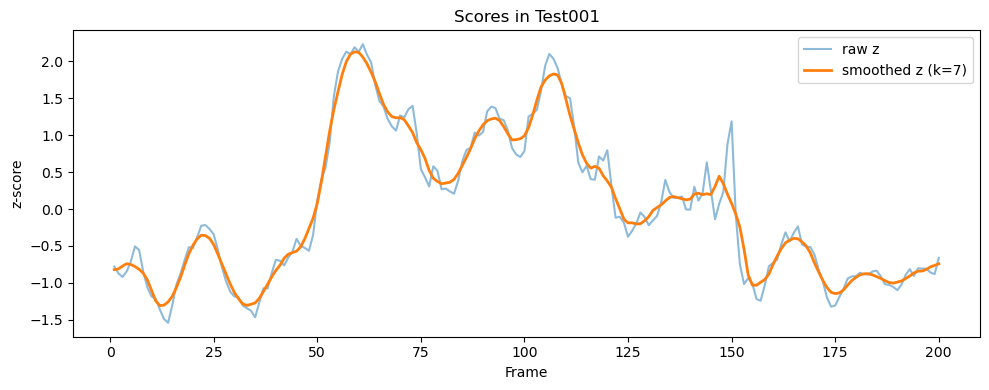

In [26]:
import matplotlib.pyplot as plt

clip_demo = df["clip"].unique()[0]  # pick any, or set e.g. "Test003"
d = df[df["clip"]==clip_demo].sort_values("frame_idx")
plt.figure(figsize=(10,4))
plt.plot(d["frame_idx"], d["z"], alpha=0.5, label="raw z")
plt.plot(d["frame_idx"], d["z_smooth"], linewidth=2, label="smoothed z (k=7)")
plt.title(f"Scores in {clip_demo}")
plt.xlabel("Frame"); plt.ylabel("z-score")
plt.legend(); plt.tight_layout(); plt.show()


In [27]:
import os, glob, re, math, random
import numpy as np
from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# dataset root (yours)
ped1_root = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi"
train_root = os.path.join(ped1_root, "Train")
assert os.path.isdir(train_root)

# transforms (match your earlier ones)
to_tensor = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64), interpolation=Image.BILINEAR),
    transforms.ToTensor()
])

class Ped1TrainFrames(Dataset):
    def __init__(self, root_dir):
        self.paths = sorted(glob.glob(os.path.join(root_dir, "Train*", "*.tif")))
        if not self.paths:
            raise RuntimeError("No train .tif frames found.")
        self.to_tensor = to_tensor
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        return self.to_tensor(img)

# Model (same as before)
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,8,3,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(8,16,3,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(16,32,3,2,1), nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,2,1,1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16,8,3,2,1,1),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8,1,3,2,1,1),   nn.Sigmoid(),
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [28]:
full_ds = Ped1TrainFrames(train_root)
n_total = len(full_ds)
n_val   = max(1, int(0.1 * n_total))   # 10% validation
n_train = n_total - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(f"Train frames: {n_train} | Val frames: {n_val}")


Train frames: 6120 | Val frames: 680


In [29]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

model = SimpleAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)

epochs = 30                  # try 20–30
patience = 6                 # early stop patience (epochs without val improvement)
best_val = float("inf")
no_improve = 0

os.makedirs("checkpoints", exist_ok=True)
best_path = "checkpoints/ped1_autoencoder_best.pt"

def run_epoch(loader, train=True):
    if train: 
        model.train()
    else:
        model.eval()
    total, count = 0.0, 0
    with torch.set_grad_enabled(train):
        for x in loader:
            x = x.to(device)
            if train:
                optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x)
            if train:
                loss.backward()
                optimizer.step()
            total += loss.item() * x.size(0)
            count += x.size(0)
    return total / max(1, count)

for ep in range(1, epochs+1):
    t0 = time.time()
    tr_loss = run_epoch(train_loader, train=True)
    va_loss = run_epoch(val_loader,   train=False)
    dt = time.time() - t0

    scheduler.step(va_loss)
    print(f"Epoch {ep:02d}/{epochs} | train {tr_loss:.6f} | val {va_loss:.6f} | lr {optimizer.param_groups[0]['lr']:.1e} | {dt:.1f}s")

    if va_loss < best_val - 1e-6:
        best_val = va_loss
        no_improve = 0
        torch.save(model.state_dict(), best_path)
        print(f"  ✅ Saved best -> {best_path} (val {best_val:.6f})")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("  ⏹ Early stopping: no improvement.")
            break

print("Best val loss:", best_val)


C:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/30 | train 0.026856 | val 0.008575 | lr 1.0e-03 | 110.3s
  ✅ Saved best -> checkpoints/ped1_autoencoder_best.pt (val 0.008575)
Epoch 02/30 | train 0.005695 | val 0.003992 | lr 1.0e-03 | 9.9s
  ✅ Saved best -> checkpoints/ped1_autoencoder_best.pt (val 0.003992)
Epoch 03/30 | train 0.003527 | val 0.003082 | lr 1.0e-03 | 9.9s
  ✅ Saved best -> checkpoints/ped1_autoencoder_best.pt (val 0.003082)
Epoch 04/30 | train 0.002918 | val 0.002643 | lr 1.0e-03 | 9.8s
  ✅ Saved best -> checkpoints/ped1_autoencoder_best.pt (val 0.002643)
Epoch 05/30 | train 0.002573 | val 0.002370 | lr 1.0e-03 | 9.7s
  ✅ Saved best -> checkpoints/ped1_autoencoder_best.pt (val 0.002370)
Epoch 06/30 | train 0.002337 | val 0.002177 | lr 1.0e-03 | 10.0s
  ✅ Saved best -> checkpoints/ped1_autoencoder_best.pt (val 0.002177)
Epoch 07/30 | train 0.002166 | val 0.002047 | lr 1.0e-03 | 9.9s
  ✅ Saved best -> checkpoints/ped1_autoencoder_best.pt (val 0.002047)
Epoch 08/30 | train 0.002034 | val 0.001913 | lr 1.0e-03 | 

In [30]:
best_path = "checkpoints/ped1_autoencoder_best.pt"
model = SimpleAutoencoder().to(device)
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()
print("Loaded best model:", best_path)


Loaded best model: checkpoints/ped1_autoencoder_best.pt


C:\Users\hp\AppData\Local\Temp\ipykernel_12596\3309474642.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device

In [31]:
# RESCORE (robust loader with PIL→OpenCV fallback)

import os, glob, re, numpy as np, pandas as pd
from PIL import Image
import cv2, torch, torch.nn.functional as F
from torchvision import transforms

ped1_root = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi"
test_root = os.path.join(ped1_root, "Test")
assert os.path.isdir(test_root)

to_tensor = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((64,64), interpolation=Image.BILINEAR),
    transforms.ToTensor()
])

def natural_key(s):
    import re
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def read_frame_tensor(path):
    try:
        return to_tensor(Image.open(path))
    except Exception:
        arr = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if arr is None: raise OSError(f"Cannot read image: {path}")
        arr = cv2.resize(arr, (64,64), interpolation=cv2.INTER_AREA)
        arr = (arr.astype(np.float32)/255.0)[None, ...]
        return torch.from_numpy(arr)

model.eval()
device = next(model.parameters()).device

rows = []
clip_dirs = sorted([d for d in glob.glob(os.path.join(test_root, "Test*")) if os.path.isdir(d)], key=natural_key)
print("Test clips:", len(clip_dirs))

for clip_dir in clip_dirs:
    clip = os.path.basename(clip_dir)
    frame_paths = sorted(glob.glob(os.path.join(clip_dir, "*.tif")), key=natural_key)
    if not frame_paths:
        print("⚠️ No .tif in", clip_dir); continue

    tensors = []
    for p in frame_paths:
        try: tensors.append(read_frame_tensor(p))
        except Exception: tensors.append(None)

    recon_errors = np.full(len(tensors), np.nan, dtype=np.float32)
    B, i = 128, 0
    while i < len(tensors):
        idxs, batch = [], []
        while i < len(tensors) and len(batch) < B:
            if tensors[i] is not None:
                idxs.append(i); batch.append(tensors[i])
            i += 1
        if not batch: continue
        x = torch.stack(batch).to(device)
        with torch.no_grad():
            y = model(x)
            err = F.mse_loss(y, x, reduction="none").mean((1,2,3)).cpu().numpy()
        for j, e in zip(idxs, err):
            recon_errors[j] = float(e)

    for k, (p, e) in enumerate(zip(frame_paths, recon_errors), start=1):
        rows.append([clip, k, os.path.basename(p), e])

scores_df = pd.DataFrame(rows, columns=["clip","frame_idx","frame","recon_error"])
os.makedirs("outputs", exist_ok=True)
scores_csv = "outputs/ped1_scores_bestmodel.csv"
scores_df.to_csv(scores_csv, index=False)
print("✅ Saved:", scores_csv, "| rows:", len(scores_df), "| NaNs:", scores_df["recon_error"].isna().sum())


Test clips: 36
✅ Saved: outputs/ped1_scores_bestmodel.csv | rows: 7200 | NaNs: 0


In [32]:
# MERGE + METRICS
import os, glob, numpy as np, pandas as pd, cv2
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix

test_gt_root = os.path.join(ped1_root, "TestGT")
assert os.path.isdir(test_gt_root)

def natural_key(s):
    import re
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def build_gt_df(root):
    rows = []
    exts = ("*.bmp","*.png","*.jpg")
    clip_dirs = sorted(glob.glob(os.path.join(root, "Test*")), key=natural_key)
    for d in clip_dirs:
        clip = os.path.basename(d).replace("_gt","")
        files = []
        for ext in exts: files += glob.glob(os.path.join(d, ext))
        files = sorted(files, key=natural_key)
        for i, fp in enumerate(files, start=1):
            m = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
            is_anom = int((m is not None) and (m>0).any())
            rows.append([clip, i, is_anom])
    return pd.DataFrame(rows, columns=["clip","frame_idx","is_anomaly"])

gt_df = build_gt_df(test_gt_root)

eval_df = pd.merge(scores_df, gt_df, on=["clip","frame_idx"], how="inner").dropna(subset=["recon_error"])
y = eval_df["is_anomaly"].astype(int).to_numpy()
s = eval_df["recon_error"].astype(float).to_numpy()

roc = roc_auc_score(y, s) if (y.min()==0 and y.max()==1) else float('nan')
P,R,T = precision_recall_curve(y, s)
pr = auc(R,P)

best = {"f1":-1, "thr":None, "prec":None, "rec":None}
for p,r,t in zip(P[:-1], R[:-1], T):
    if p+r>0:
        f1 = 2*p*r/(p+r)
        if f1 > best["f1"]:
            best = {"f1":float(f1), "thr":float(t), "prec":float(p), "rec":float(r)}

yhat = (s >= best["thr"]).astype(int)
tn, fp, fn, tp = confusion_matrix(y, yhat, labels=[0,1]).ravel()

print("\n=== Best model (raw) ===")
print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f} | F1: {best['f1']:.3f} @ thr={best['thr']:.6f}")
print(f"Precision: {best['prec']:.3f} | Recall: {best['rec']:.3f}")
print(f"CM -> TP:{tp} FP:{fp} TN:{tn} FN:{fn}")

# OPTIONAL: per-clip z-normalization + smoothing (k=7) to boost precision
import pandas as pd, numpy as np
df2 = eval_df.copy()
df2["z"] = df2.groupby("clip")["recon_error"].transform(lambda s: (s - s.mean())/(s.std()+1e-8))

def movavg(a, k=7):
    k = int(k); pad = k//2
    left = np.repeat(a[:1], pad); right = np.repeat(a[-1:], pad)
    ap = np.concatenate([left, a, right])
    return np.convolve(ap, np.ones(k)/k, mode="valid")

df2["z_smooth"] = df2.groupby("clip")["z"].transform(lambda s: pd.Series(movavg(s.values, 7), index=s.index))

P2,R2,T2 = precision_recall_curve(y, df2["z_smooth"].values)
pr2 = auc(R2,P2)
best2 = {"f1":-1, "thr":None, "prec":None, "rec":None}
for p,r,t in zip(P2[:-1], R2[:-1], T2):
    if p+r>0:
        f1 = 2*p*r/(p+r)
        if f1 > best2["f1"]:
            best2 = {"f1":float(f1), "thr":float(t), "prec":float(p), "rec":float(r)}
yhat2 = (df2["z_smooth"].values >= best2["thr"]).astype(int)
tn2, fp2, fn2, tp2 = confusion_matrix(y, yhat2, labels=[0,1]).ravel()

print("\n=== Best model + clip-z + smoothing ===")
print(f"PR-AUC: {pr2:.3f} | F1: {best2['f1']:.3f} @ thr={best2['thr']:.4f}")
print(f"Precision: {best2['prec']:.3f} | Recall: {best2['rec']:.3f}")
print(f"CM -> TP:{tp2} FP:{fp2} TN:{tn2} FN:{fn2}")



=== Best model (raw) ===
ROC-AUC: 0.619 | PR-AUC: 0.725 | F1: 0.796 @ thr=0.000925
Precision: 0.671 | Recall: 0.981
CM -> TP:1211 FP:595 TN:170 FN:24

=== Best model + clip-z + smoothing ===
PR-AUC: 0.719 | F1: 0.782 @ thr=-0.9778
Precision: 0.676 | Recall: 0.927
CM -> TP:1145 FP:549 TN:216 FN:90


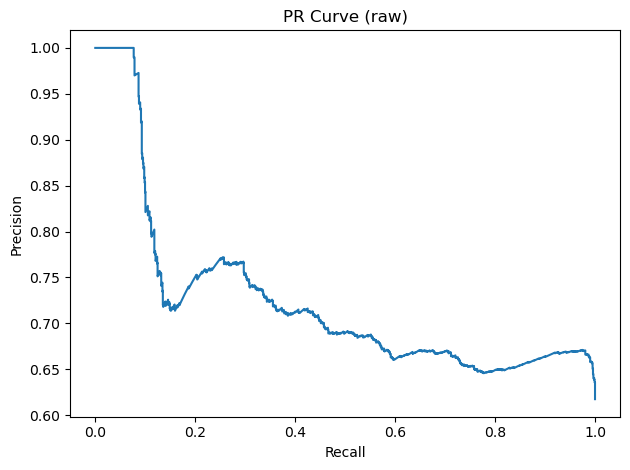

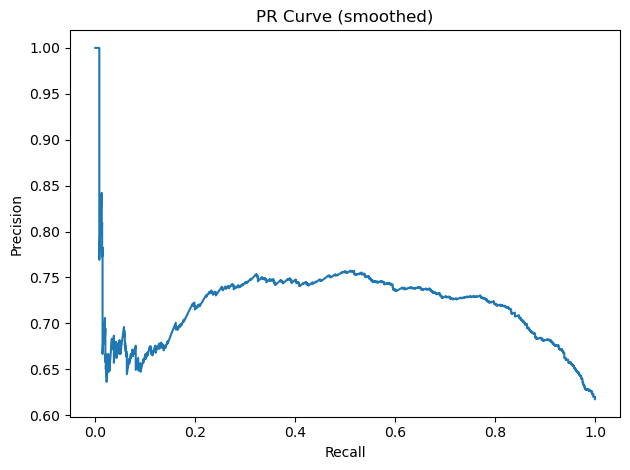

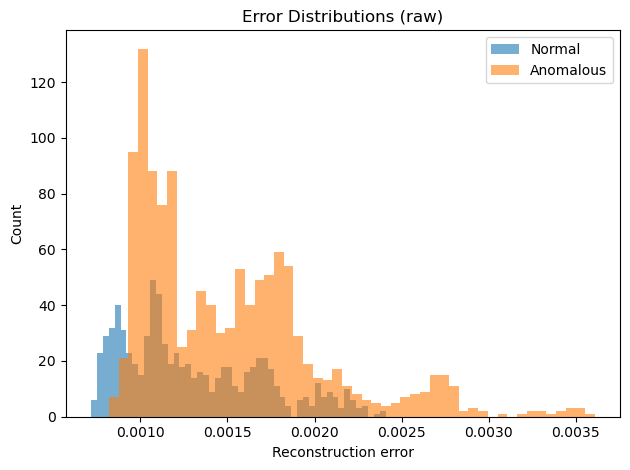

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# PR curve (raw scores)
P,R,_ = precision_recall_curve(y, s)
plt.figure(); plt.plot(R,P)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (raw)"); plt.tight_layout()
plt.savefig("outputs/pr_curve_raw.png", dpi=200); plt.show()

# PR curve (smoothed)
P3,R3,_ = precision_recall_curve(y, df2["z_smooth"].values)
plt.figure(); plt.plot(R3,P3)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (smoothed)"); plt.tight_layout()
plt.savefig("outputs/pr_curve_smoothed.png", dpi=200); plt.show()

# Error histogram
plt.figure()
plt.hist(s[y==0], bins=50, alpha=0.6, label="Normal")
plt.hist(s[y==1], bins=50, alpha=0.6, label="Anomalous")
plt.xlabel("Reconstruction error"); plt.ylabel("Count"); plt.title("Error Distributions (raw)")
plt.legend(); plt.tight_layout()
plt.savefig("outputs/error_hist_raw.png", dpi=200); plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_12596\3341295434.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=devic

RAW -> ROC-AUC 0.619 | PR-AUC 0.725 | F1 0.796  P 0.671 R 0.981
SMOOTH -> PR-AUC 0.719 | F1 0.782  P 0.676 R 0.927


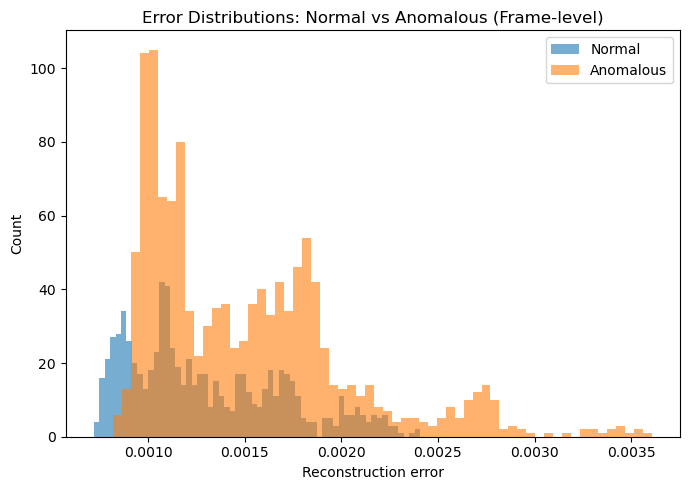

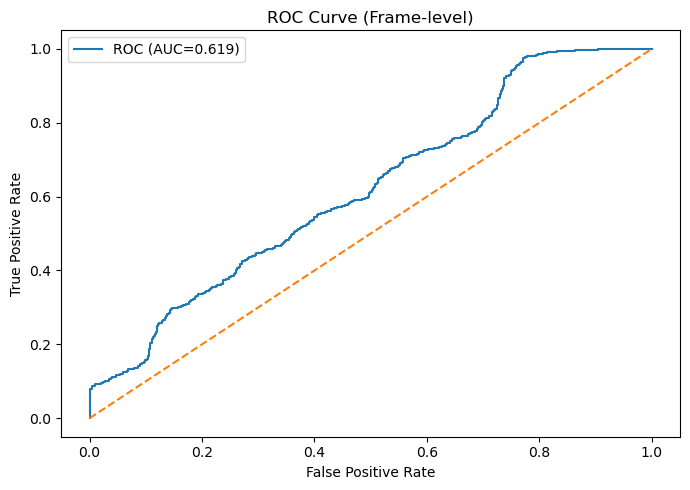

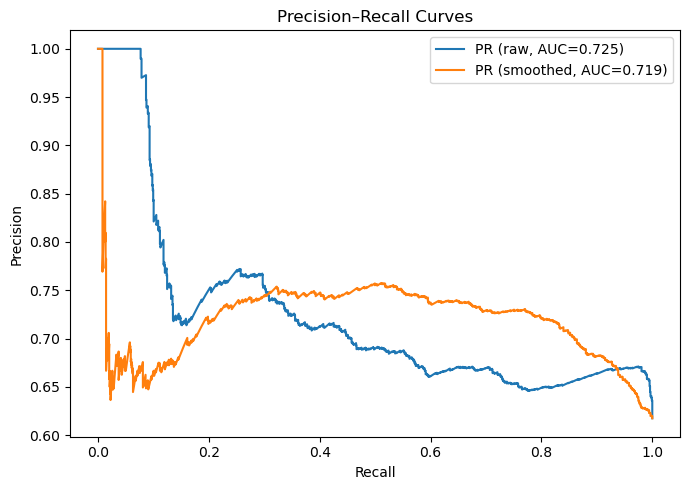

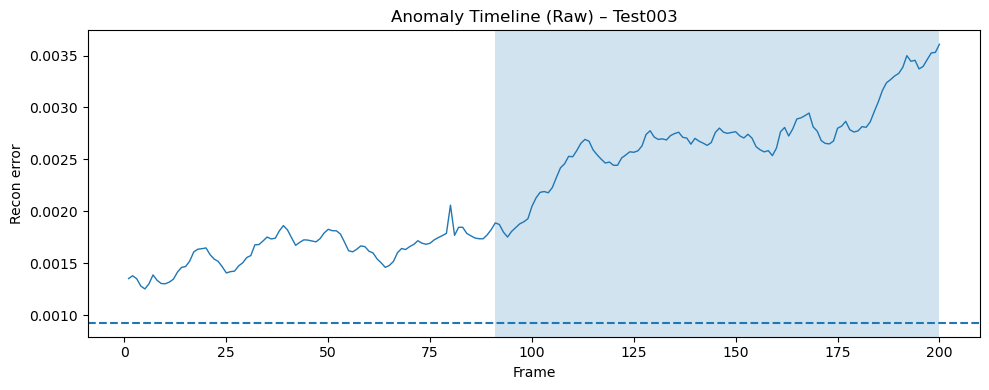

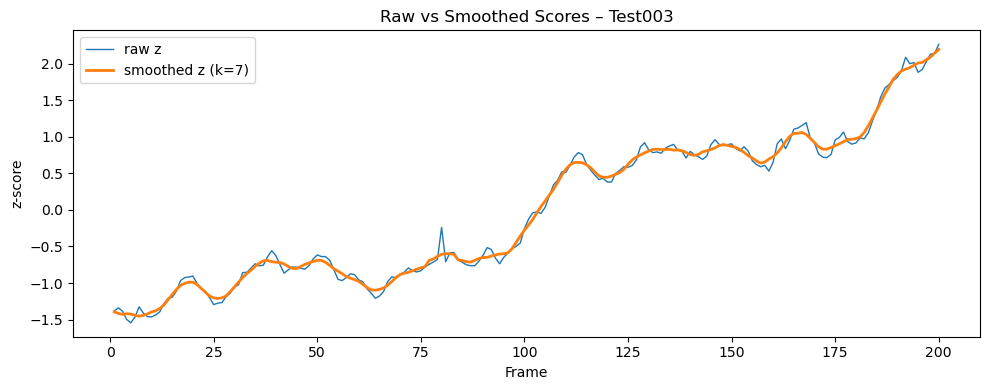

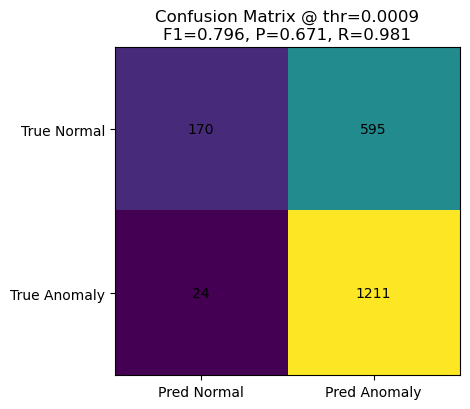


Saved figures:
 - outputs\fig_error_distributions.png True
 - outputs\fig_roc.png True
 - outputs\fig_pr_curves.png True
 - outputs\fig_timeline_raw.png True
 - outputs\fig_raw_vs_smoothed.png True
 - outputs\fig_confusion_matrix.png True


In [34]:
# === CONFIG ===
import os, glob, re, json
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve

# paths
ped1_root = r"C:\Users\hp\Downloads\UCSD_Anomaly_Dataset\UCSD_Anomaly_Dataset.v1p2\UCSDped1.avi"
test_root = os.path.join(ped1_root, "Test")
test_gt_root = os.path.join(ped1_root, "TestGT")
os.makedirs("outputs", exist_ok=True)

# -------- util helpers --------
def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def build_gt_df(root):
    rows, exts = [], ("*.bmp","*.png","*.jpg")
    clip_dirs = sorted(glob.glob(os.path.join(root, "Test*")), key=natural_key)
    for d in clip_dirs:
        clip = os.path.basename(d).replace("_gt","")
        files = []
        for ext in exts: files += glob.glob(os.path.join(d, ext))
        files = sorted(files, key=natural_key)
        for i, fp in enumerate(files, start=1):
            m = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
            is_anom = int((m is not None) and (m>0).any())
            rows.append([clip, i, is_anom])
    return pd.DataFrame(rows, columns=["clip","frame_idx","is_anomaly"])

# model (same as your training)
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,8,3,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(8,16,3,2,1), nn.ReLU(inplace=True),
            nn.Conv2d(16,32,3,2,1), nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,2,1,1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16,8,3,2,1,1),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8,1,3,2,1,1),   nn.Sigmoid(),
        )
    def forward(self, x): return self.decoder(self.encoder(x))

# -------- load best model (no retrain) --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleAutoencoder().to(device)
best_path = "checkpoints/ped1_autoencoder_best.pt"
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

# -------- load or compute scores_df --------
scores_csv_candidates = [
    "outputs/ped1_scores_bestmodel.csv",
    "outputs/ped1_frame_scores_robust.csv",
    "outputs/ped1_frame_scores_with_idx.csv"
]
scores_df = None
for p in scores_csv_candidates:
    if os.path.isfile(p):
        scores_df = pd.read_csv(p)
        break
if scores_df is None:
    # robust rescoring (PIL -> OpenCV fallback), includes frame_idx 1-based
    to_tensor = transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize((64,64), interpolation=Image.BILINEAR),
        transforms.ToTensor()
    ])
    def read_frame_tensor(path):
        try:
            return to_tensor(Image.open(path))
        except Exception:
            arr = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if arr is None: raise OSError(f"Cannot read image: {path}")
            arr = cv2.resize(arr, (64,64), interpolation=cv2.INTER_AREA)
            arr = (arr.astype(np.float32)/255.0)[None, ...]
            return torch.from_numpy(arr)
    rows = []
    clip_dirs = sorted([d for d in glob.glob(os.path.join(test_root, "Test*")) if os.path.isdir(d)], key=natural_key)
    for clip_dir in clip_dirs:
        clip = os.path.basename(clip_dir)
        frame_paths = sorted(glob.glob(os.path.join(clip_dir, "*.tif")), key=natural_key)
        if not frame_paths: continue
        tensors = []
        for p in frame_paths:
            try: tensors.append(read_frame_tensor(p))
            except Exception: tensors.append(None)
        errs = np.full(len(tensors), np.nan, dtype=np.float32)
        B, i = 128, 0
        while i < len(tensors):
            idxs, batch = [], []
            while i < len(tensors) and len(batch) < B:
                if tensors[i] is not None:
                    idxs.append(i); batch.append(tensors[i])
                i += 1
            if not batch: continue
            x = torch.stack(batch).to(device)
            with torch.no_grad():
                y = model(x)
                e = F.mse_loss(y, x, reduction="none").mean((1,2,3)).cpu().numpy()
            for j, val in zip(idxs, e): errs[j] = float(val)
        for k, (p, e) in enumerate(zip(frame_paths, errs), start=1):
            rows.append([clip, k, os.path.basename(p), e])
    scores_df = pd.DataFrame(rows, columns=["clip","frame_idx","frame","recon_error"])
    scores_df.to_csv("outputs/ped1_scores_bestmodel.csv", index=False)

# drop NaNs if any
scores_df = scores_df.dropna(subset=["recon_error"]).copy()

# -------- build GT, merge, and compute metrics --------
gt_df = build_gt_df(test_gt_root)
eval_df = pd.merge(scores_df, gt_df, on=["clip","frame_idx"], how="inner")
y_true = eval_df["is_anomaly"].astype(int).to_numpy()
scores = eval_df["recon_error"].astype(float).to_numpy()

# raw metrics
roc = roc_auc_score(y_true, scores) if (y_true.min()==0 and y_true.max()==1) else float('nan')
P,R,T = precision_recall_curve(y_true, scores); pr = auc(R,P)
best = {"f1":-1,"thr":None,"prec":None,"rec":None}
for p,r,t in zip(P[:-1], R[:-1], T):
    if p+r>0:
        f1 = 2*p*r/(p+r)
        if f1 > best["f1"]:
            best = {"f1":float(f1), "thr":float(t), "prec":float(p), "rec":float(r)}
yhat = (scores >= best["thr"]).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()

# smoothed scores (per-clip z + moving average)
def movavg(a, k=7):
    k = int(k); pad = k//2
    left = np.repeat(a[:1], pad); right = np.repeat(a[-1:], pad)
    ap = np.concatenate([left, a, right])
    return np.convolve(ap, np.ones(k)/k, mode="valid")

df2 = eval_df.copy()
df2["z"] = df2.groupby("clip")["recon_error"].transform(lambda s: (s - s.mean())/(s.std()+1e-8))
df2["z_smooth"] = df2.groupby("clip")["z"].transform(lambda s: pd.Series(movavg(s.values, 7), index=s.index))
scores_smooth = df2["z_smooth"].to_numpy()
P2,R2,T2 = precision_recall_curve(y_true, scores_smooth); pr2 = auc(R2,P2)
best2={"f1":-1,"thr":None,"prec":None,"rec":None}
for p,r,t in zip(P2[:-1], R2[:-1], T2):
    if p+r>0:
        f12 = 2*p*r/(p+r)
        if f12>best2["f1"]:
            best2={"f1":float(f12),"thr":float(t),"prec":float(p),"rec":float(r)}
yhat2 = (scores_smooth >= best2["thr"]).astype(int)
tn2, fp2, fn2, tp2 = confusion_matrix(y_true, yhat2, labels=[0,1]).ravel()

print(f"RAW -> ROC-AUC {roc:.3f} | PR-AUC {pr:.3f} | F1 {best['f1']:.3f}  P {best['prec']:.3f} R {best['rec']:.3f}")
print(f"SMOOTH -> PR-AUC {pr2:.3f} | F1 {best2['f1']:.3f}  P {best2['prec']:.3f} R {best2['rec']:.3f}")

# Pick a clip with anomalies for timeline plots
clip_has_anom = df2.groupby("clip")["is_anomaly"].sum()
if (clip_has_anom>0).any():
    clip_demo = clip_has_anom[clip_has_anom>0].index.tolist()[0]
else:
    clip_demo = df2["clip"].unique()[0]
demo = df2[df2["clip"]==clip_demo].sort_values("frame_idx")

# === 1) Error distribution (hist) ===
plt.figure(figsize=(7,5))
plt.hist(scores[y_true==0], bins=60, alpha=0.6, label="Normal")
plt.hist(scores[y_true==1], bins=60, alpha=0.6, label="Anomalous")
plt.xlabel("Reconstruction error"); plt.ylabel("Count")
plt.title("Error Distributions: Normal vs Anomalous (Frame-level)")
plt.legend(); plt.tight_layout()
plt.savefig("outputs/fig_error_distributions.png", dpi=220); plt.show()

# === 2) ROC & PR curves ===
# ROC may be NaN if single-class; guard:
plt.figure(figsize=(7,5))
if not np.isnan(roc):
    fpr, tpr, _ = roc_curve(y_true, scores)
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Frame-level)"); plt.legend(); plt.tight_layout()
    plt.savefig("outputs/fig_roc.png", dpi=220); plt.show()

plt.figure(figsize=(7,5))
plt.plot(R, P, label=f"PR (raw, AUC={pr:.3f})")
plt.plot(R2, P2, label=f"PR (smoothed, AUC={pr2:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves"); plt.legend(); plt.tight_layout()
plt.savefig("outputs/fig_pr_curves.png", dpi=220); plt.show()

# === 3) Anomaly score timeline with GT shading (demo clip) ===
plt.figure(figsize=(10,4))
plt.plot(demo["frame_idx"], demo["recon_error"], linewidth=1)
plt.axhline(best["thr"], linestyle="--")
# Shade GT anomaly regions
mask = demo["is_anomaly"].values.astype(bool)
# group contiguous anomaly frames
if mask.any():
    idxs = demo["frame_idx"].values
    start = None
    for i, m in zip(idxs, mask):
        if m and start is None:
            start = i
        if (not m and start is not None):
            plt.axvspan(start, i-1, alpha=0.2)
            start = None
    if start is not None:  # tail
        plt.axvspan(start, idxs[-1], alpha=0.2)
plt.xlabel("Frame"); plt.ylabel("Recon error")
plt.title(f"Anomaly Timeline (Raw) – {clip_demo}")
plt.tight_layout(); plt.savefig("outputs/fig_timeline_raw.png", dpi=220); plt.show()

# === 4) Raw vs Smoothed scores (same clip) ===
plt.figure(figsize=(10,4))
plt.plot(demo["frame_idx"], demo["z"],  linewidth=1, label="raw z")
plt.plot(demo["frame_idx"], demo["z_smooth"], linewidth=2, label="smoothed z (k=7)")
plt.xlabel("Frame"); plt.ylabel("z-score")
plt.title(f"Raw vs Smoothed Scores – {clip_demo}")
plt.legend(); plt.tight_layout()
plt.savefig("outputs/fig_raw_vs_smoothed.png", dpi=220); plt.show()

# === 5) Confusion matrix heatmap (best-F1, raw) ===
from matplotlib.colors import LogNorm
cm = np.array([[tn, fp],[fn, tp]], dtype=int)
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, aspect="auto")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xticks([0,1], ["Pred Normal","Pred Anomaly"])
plt.yticks([0,1], ["True Normal","True Anomaly"])
plt.title(f"Confusion Matrix @ thr={best['thr']:.4f}\nF1={best['f1']:.3f}, P={best['prec']:.3f}, R={best['rec']:.3f}")
plt.tight_layout(); plt.savefig("outputs/fig_confusion_matrix.png", dpi=220); plt.show()

print("\nSaved figures:")
for f in ["fig_error_distributions.png","fig_roc.png","fig_pr_curves.png",
          "fig_timeline_raw.png","fig_raw_vs_smoothed.png","fig_confusion_matrix.png"]:
    p = os.path.join("outputs", f)
    print(" -", p, os.path.isfile(p))


In [35]:
train_hist, val_hist = [], []

In [36]:
train_hist.append(float(tr_loss))
val_hist.append(float(va_loss))
with open("outputs/loss_history.json","w") as f:
    json.dump({"train":train_hist, "val":val_hist}, f)


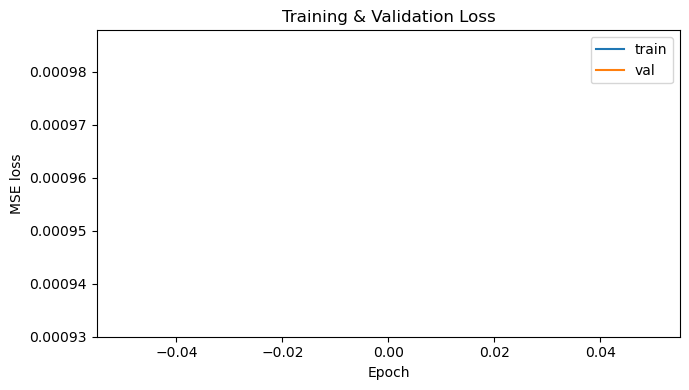

In [37]:
import json, matplotlib.pyplot as plt
with open("outputs/loss_history.json") as f:
    h = json.load(f)
plt.figure(figsize=(7,4))
plt.plot(h["train"], label="train")
plt.plot(h["val"],   label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE loss")
plt.title("Training & Validation Loss")
plt.legend(); plt.tight_layout()
plt.savefig("outputs/fig_training_curves.png", dpi=220); plt.show()


In [38]:
train_hist, val_hist = [], []

for epoch in range(num_epochs):
    # your normal training loop...

    train_hist.append(float(tr_loss))
    val_hist.append(float(va_loss))

# save after all epochs
import json
with open("outputs/loss_history.json","w") as f:
    json.dump({"train":train_hist, "val":val_hist}, f)


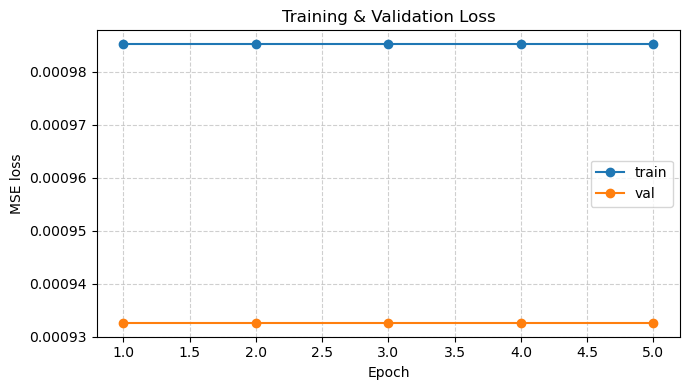

In [39]:
import json
import matplotlib.pyplot as plt

with open("outputs/loss_history.json") as f:
    h = json.load(f)

epochs = range(1, len(h["train"]) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, h["train"], label="train", marker='o')
plt.plot(epochs, h["val"], label="val", marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("outputs/fig_training_curves.png", dpi=220)
plt.show()


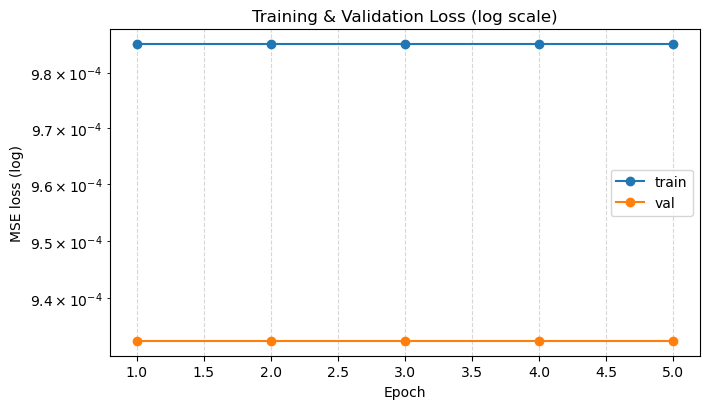

In [40]:
import json, matplotlib.pyplot as plt
with open("outputs/loss_history.json") as f:
    h = json.load(f)

epochs = range(1, len(h["train"])+1)

plt.figure(figsize=(7.2,4.2))
plt.plot(epochs, h["train"], marker='o', label="train")
plt.plot(epochs, h["val"],   marker='o', label="val")
plt.yscale("log")  # <— key change
plt.xlabel("Epoch"); plt.ylabel("MSE loss (log)")
plt.title("Training & Validation Loss (log scale)")
plt.grid(True, ls='--', alpha=0.5); plt.legend()
plt.tight_layout(); plt.savefig("outputs/fig_training_curves_log.png", dpi=220); plt.show()


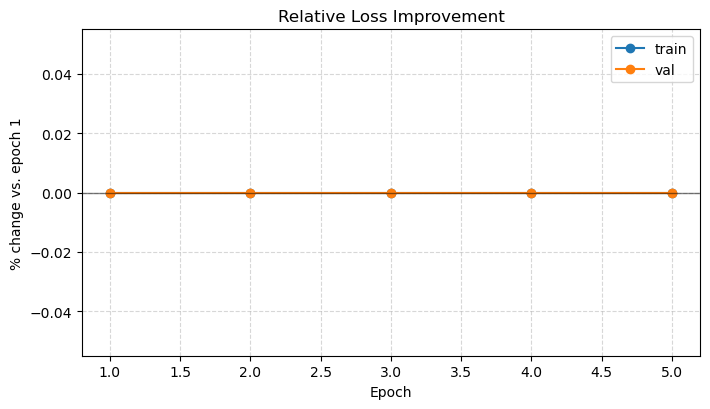

In [41]:
import numpy as np, json, matplotlib.pyplot as plt
with open("outputs/loss_history.json") as f:
    h = json.load(f)

t0, v0 = h["train"][0], h["val"][0]
train_rel = (np.array(h["train"])/t0 - 1.0) * 100
val_rel   = (np.array(h["val"])  /v0 - 1.0) * 100
epochs = range(1, len(h["train"])+1)

plt.figure(figsize=(7.2,4.2))
plt.plot(epochs, train_rel, marker='o', label="train")
plt.plot(epochs, val_rel,   marker='o', label="val")
plt.axhline(0, color='k', lw=1, alpha=0.5)
plt.xlabel("Epoch"); plt.ylabel("% change vs. epoch 1")
plt.title("Relative Loss Improvement")
plt.grid(True, ls='--', alpha=0.5); plt.legend()
plt.tight_layout(); plt.savefig("outputs/fig_training_curves_relative.png", dpi=220); plt.show()


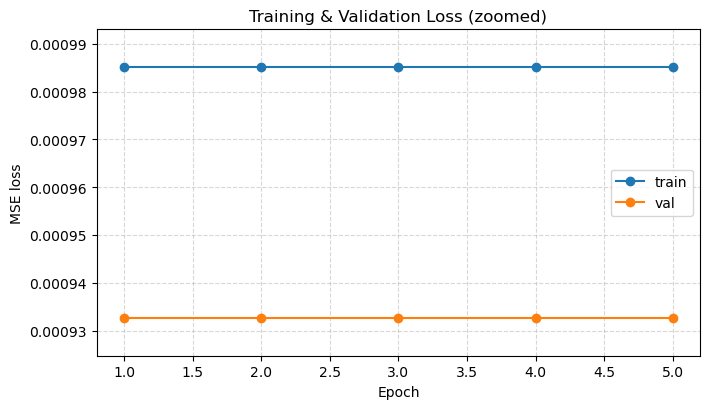

In [42]:
import json, matplotlib.pyplot as plt
with open("outputs/loss_history.json") as f:
    h = json.load(f)

epochs = range(1, len(h["train"])+1)
y_all = h["train"] + h["val"]
y_min, y_max = min(y_all), max(y_all)
pad = (y_max - y_min) * 0.15 if y_max > y_min else 1e-4

plt.figure(figsize=(7.2,4.2))
plt.plot(epochs, h["train"], marker='o', label="train")
plt.plot(epochs, h["val"],   marker='o', label="val")
plt.ylim(max(0, y_min - pad), y_max + pad)  # <-- zoom into the action
plt.xlabel("Epoch"); plt.ylabel("MSE loss")
plt.title("Training & Validation Loss (zoomed)")
plt.grid(True, ls='--', alpha=0.5); plt.legend()
plt.tight_layout(); plt.savefig("outputs/fig_training_curves_zoom.png", dpi=220); plt.show()
